# MNIST with SciKit-Learn and PyTroch

This notebooks shows how to define and train a simple modern Neural-Network with PyTorch and SciKit-Learn.

The socalled "LeNet" architecture is used here.


<a target="_blank" href="https://colab.research.google.com/github/AI4EPS/EPS88_PyEarth/blob/master/docs/lectures/10_neural_networks2.ipynb">
<img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>  

**Note**: If you are running this in [a colab notebook](https://colab.research.google.com/github/skorch-dev/skorch/blob/master/notebooks/MNIST.ipynb), we recommend you enable a free GPU by going:

> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**


In [1]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm

## Loading Data
Using SciKit-Learns ```fetch_openml``` to load MNIST data.

In [2]:
mnist = fetch_openml('mnist_784', as_frame=False)

In [3]:
print(f"MNIST data shape: {mnist.data.shape}, data type: {mnist.data.dtype}")
print(f"MNIST target shape: {mnist.target.shape}, target type: {mnist.target.dtype}")

MNIST data shape: (70000, 784), data type: int64
MNIST target shape: (70000,), target type: object


Each image of the MNIST dataset is encoded in a 784 dimensional vector, representing a 28 x 28 pixel image.

Each pixel has a value between 0 and 255, corresponding to the grey-value of a pixel.


## Preprocessing Data

The above ```featch_mldata``` method to load MNIST returns ```data``` and ```target``` as ```uint8``` which we convert to ```float32``` and ```int64``` respectively.

To avoid big weights that deal with the pixel values from between [0, 255], we scale `X` down. A commonly used range is [0, 1].


In [4]:
X = mnist.data.astype('float32')
y = mnist.target.astype('int64')

X /= 255.0
print(f"{X.min() = }, {X.max() = }")

X.min() = 0.0, X.max() = 1.0


Same as prevoious lectures, let split the data into training and testing sets.

In [5]:
## Split data into training and testing sets using 30% of the data for testing and random seed 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Visualize a selection of training images and their labels


In [6]:
## Define a function to plot a selection of images and their labels
def plot_example(X, y, n_samples=10):
    """Plot the first n_samples images and their labels in a row."""
    fig, axes = plt.subplots(1, n_samples, figsize=(2*n_samples, 4))
    for i, ax in enumerate(axes):
        ax.imshow(X[i].reshape(28, 28), cmap='gray')
        ax.set_title(y[i], fontsize=32)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

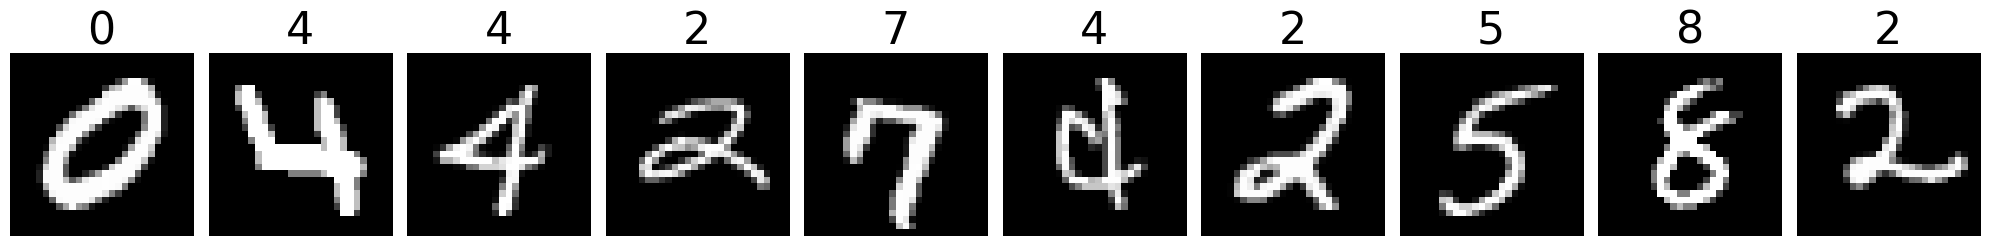

In [7]:
plot_example(X_train, y_train)

## Build Neural Network with PyTorch

In the previous lecture, we have built a simple fully connected neural network with one hidden layer for both linear regression and classification tasks. Let's try a similar network for the classification task of MNIST.

Note the dataset is much larger than our previous examples, so we need to adjust the network size accordingly.
(It is still tiny compared to modern standards)

Let's think about the network architecture:

- Input layer: 784 dimensions (28x28). This is defined by the MNIST data shape.
- Hidden layer: 98 (= 784 / 8). This is a free parameter that we can choose.
- Output layer: 10 neurons, representing digits 0 - 9. This is defined by the number of classes in the dataset.

- Load PyTorch for deep learning

In [8]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

- Prepare the data for training and testing

In [9]:
## Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.int64)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.int64)

- Build a simple fully connected neural network in PyTorch's framework.

In [10]:
## Define the network architecture: A simple fully connected neural network
class FCN(nn.Module):
    def __init__(
            self,
            input_dim=28*28,
            hidden_dim=28*4,
            output_dim=10,
            dropout=0.5,
    ):
        super(FCN, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.hidden = nn.Linear(input_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)

    def forward(self, X, **kwargs):
        X = F.relu(self.hidden(X))
        X = self.dropout(X)
        X = F.softmax(self.output(X), dim=-1)
        return X

Training Epoch 1/15: 100%|██████████| 382/382 [00:01<00:00, 204.16it/s]


Epoch 1/15: Loss: 1.7202


Training Epoch 2/15: 100%|██████████| 382/382 [00:01<00:00, 194.80it/s]


Epoch 2/15: Loss: 1.5868


Training Epoch 3/15: 100%|██████████| 382/382 [00:01<00:00, 206.48it/s]


Epoch 3/15: Loss: 1.5669


Training Epoch 4/15: 100%|██████████| 382/382 [00:01<00:00, 205.56it/s]


Epoch 4/15: Loss: 1.5557


Training Epoch 5/15: 100%|██████████| 382/382 [00:01<00:00, 225.47it/s]


Epoch 5/15: Loss: 1.5475


Training Epoch 6/15: 100%|██████████| 382/382 [00:01<00:00, 220.64it/s]


Epoch 6/15: Loss: 1.5412


Training Epoch 7/15: 100%|██████████| 382/382 [00:01<00:00, 241.79it/s]


Epoch 7/15: Loss: 1.5366


Training Epoch 8/15: 100%|██████████| 382/382 [00:01<00:00, 227.35it/s]


Epoch 8/15: Loss: 1.5317


Training Epoch 9/15: 100%|██████████| 382/382 [00:01<00:00, 238.90it/s]


Epoch 9/15: Loss: 1.5298


Training Epoch 10/15: 100%|██████████| 382/382 [00:01<00:00, 231.11it/s]


Epoch 10/15: Loss: 1.5268


Training Epoch 11/15: 100%|██████████| 382/382 [00:01<00:00, 231.26it/s]


Epoch 11/15: Loss: 1.5260


Training Epoch 12/15: 100%|██████████| 382/382 [00:01<00:00, 224.56it/s]


Epoch 12/15: Loss: 1.5221


Training Epoch 13/15: 100%|██████████| 382/382 [00:01<00:00, 214.97it/s]


Epoch 13/15: Loss: 1.5216


Training Epoch 14/15: 100%|██████████| 382/382 [00:01<00:00, 242.69it/s]


Epoch 14/15: Loss: 1.5194


Training Epoch 15/15: 100%|██████████| 382/382 [00:01<00:00, 219.04it/s]


Epoch 15/15: Loss: 1.5184


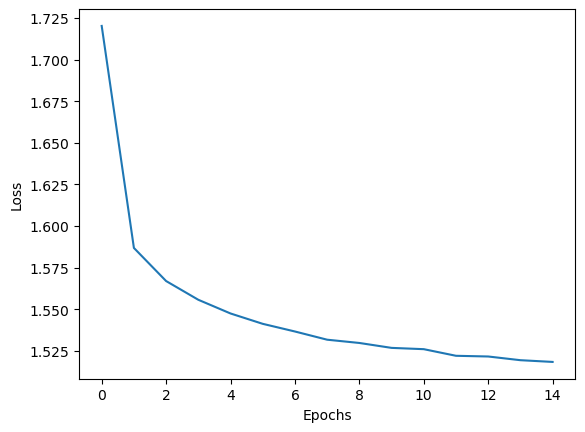

In [11]:
## Initialize the network parameters, loss function, optimizer, and device
mnist_dim = X.shape[1]
hidden_dim = int(mnist_dim/8)
output_dim = len(np.unique(mnist.target))

model = FCN(input_dim=mnist_dim, hidden_dim=hidden_dim, output_dim=output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Define the device to choose the fastest for training
## MPS for Apple Silicon, CUDA for NVidia GPUs, and CPU otherwise
device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'

## Define fit function
def fit(model, X_train, y_train, epochs=100):
    dataloader = DataLoader(dataset=TensorDataset(X_train, y_train), batch_size=128, shuffle=True, drop_last=True)
    model.to(device)
    model.train()
    losses = []
    for epoch in range(epochs):
        loss = 0
        for X_train, y_train in tqdm(dataloader, desc=f'Training Epoch {epoch+1}/{epochs}'):
            optimizer.zero_grad()
            X_train = X_train.to(device)
            y_train = y_train.to(device)
            outputs = model(X_train)
            batch_loss = criterion(outputs, y_train)
            batch_loss.backward()
            optimizer.step()
            loss += batch_loss.item()

        # average loss per batch
        loss = loss / len(dataloader)
        losses.append(loss)

        print(f'Epoch {epoch+1}/{epochs}: Loss: {loss:.4f}')

    return losses

## Define predict function
def predict(model, X):
    dataloader = DataLoader(dataset=TensorDataset(X), batch_size=128, drop_last=False)
    model.eval()
    device = next(model.parameters()).device
    with torch.no_grad():
        predicted = []
        for X, in tqdm(dataloader, desc='Predicting'):
            X = X.to(device)
            outputs = model(X)
            _, predicted_batch = torch.max(outputs, 1)
            predicted.append(predicted_batch.cpu())
    return torch.cat(predicted)

## Train the model
losses = fit(model, X_train_tensor, y_train_tensor, epochs=15)

## Plot the loss
plt.figure()
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

- Evaluate the model on the test set. This is same as the previous lecture.

Predicting: 100%|██████████| 165/165 [00:00<00:00, 488.64it/s]


Accuracy: 0.9594


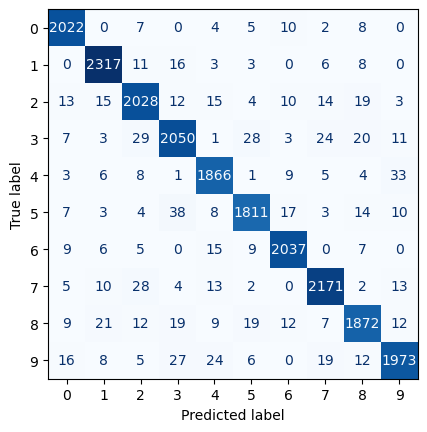

In [12]:
## Predict on the test set
y_pred_tensor = predict(model, X_test_tensor)
y_pred = y_pred_tensor.numpy()

## Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

## Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.arange(len(np.unique(y))))
disp.plot(cmap=plt.cm.Blues, values_format='d', colorbar=False);

What accuracy did you get? Is it above 95%?

An accuracy of above 95% for a network with only one hidden layer is not too bad.

Let's take a look at some predictions that went wrong:

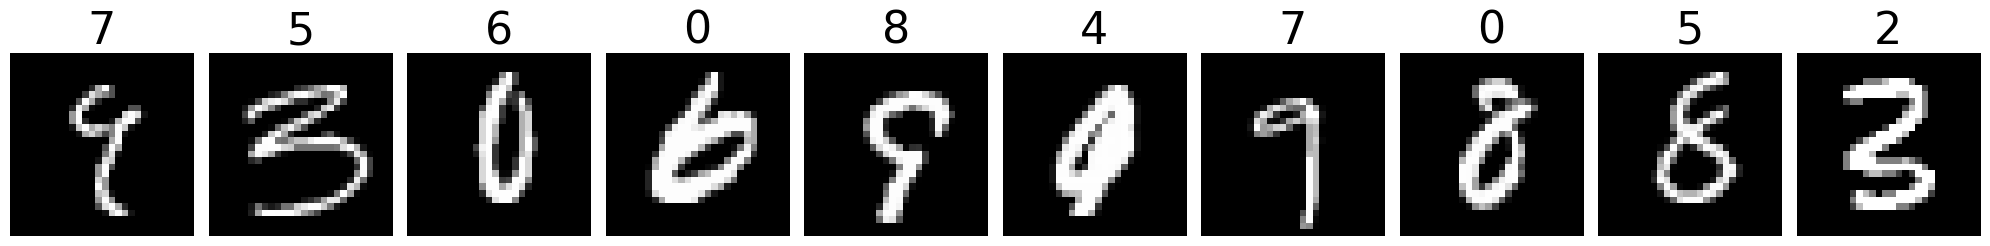

In [13]:
error_mask_fcn = y_pred != y_test
plot_example(X_test[error_mask_fcn], y_pred[error_mask_fcn])

Are these errors reasonable? 

# Convolutional Network

To further improve the performance, let's try a convolutional neural network (CNN) for MNIST. 

The 2D convolutional layer expects a 4 dimensional tensor as input. The dimensions represent:
* Batch size
* Number of channel
* Height
* Width

So we need to reshape the MNIST data to have the right shape.
MNIST data has only one channel. As stated above, each MNIST vector represents a 28x28 pixel image. Hence, the resulting shape for PyTorch tensor needs to be (x, 1, 28, 28). 

- Prepare the data for training and testing

In [14]:
## Convert data to PyTorch tensors and reshape to 4D tensor (batch_size, channel, height, width)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).reshape(-1, 1, 28, 28)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).reshape(-1, 1, 28, 28)
y_train_tensor = torch.tensor(y_train, dtype=torch.int64)
y_test_tensor = torch.tensor(y_test, dtype=torch.int64)

- Build a simple convolutional neural network in PyTorch's framework.


In [15]:
## Define the network architecture: A simple convolutional neural network
class CNN(nn.Module):
    def __init__(self, input_dim=28*28, hidden_dim=112, output_dim=10, dropout=0.5):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv2_drop = nn.Dropout2d(p=dropout)
        num_features = 64 * int((input_dim**0.5 // 4 - 2)**2)
        self.fc1 = nn.Linear(num_features, hidden_dim) # 1600 = number channels * width * height
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.fc1_drop = nn.Dropout(p=dropout)

    def forward(self, x):
    
        x = torch.relu(F.max_pool2d(self.conv1(x), 2))
        x = torch.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        
        # flatten over channel, height and width
        x = x.view(-1, x.size(1) * x.size(2) * x.size(3))
        
        x = torch.relu(self.fc1_drop(self.fc1(x)))
        x = torch.softmax(self.fc2(x), dim=-1)

        return x

Training Epoch 1/15: 100%|██████████| 382/382 [00:04<00:00, 86.08it/s] 


Epoch 1/15: Loss: 1.6656


Training Epoch 2/15: 100%|██████████| 382/382 [00:04<00:00, 90.44it/s] 


Epoch 2/15: Loss: 1.5322


Training Epoch 3/15: 100%|██████████| 382/382 [00:03<00:00, 97.28it/s] 


Epoch 3/15: Loss: 1.5143


Training Epoch 4/15: 100%|██████████| 382/382 [00:04<00:00, 93.24it/s] 


Epoch 4/15: Loss: 1.5078


Training Epoch 5/15: 100%|██████████| 382/382 [00:03<00:00, 101.60it/s]


Epoch 5/15: Loss: 1.5040


Training Epoch 6/15: 100%|██████████| 382/382 [00:03<00:00, 99.77it/s] 


Epoch 6/15: Loss: 1.4995


Training Epoch 7/15: 100%|██████████| 382/382 [00:04<00:00, 92.71it/s] 


Epoch 7/15: Loss: 1.4970


Training Epoch 8/15: 100%|██████████| 382/382 [00:03<00:00, 100.97it/s]


Epoch 8/15: Loss: 1.4942


Training Epoch 9/15: 100%|██████████| 382/382 [00:04<00:00, 95.05it/s] 


Epoch 9/15: Loss: 1.4936


Training Epoch 10/15: 100%|██████████| 382/382 [00:03<00:00, 99.49it/s] 


Epoch 10/15: Loss: 1.4923


Training Epoch 11/15: 100%|██████████| 382/382 [00:03<00:00, 99.64it/s] 


Epoch 11/15: Loss: 1.4910


Training Epoch 12/15: 100%|██████████| 382/382 [00:04<00:00, 94.42it/s] 


Epoch 12/15: Loss: 1.4907


Training Epoch 13/15: 100%|██████████| 382/382 [00:03<00:00, 102.77it/s]


Epoch 13/15: Loss: 1.4900


Training Epoch 14/15: 100%|██████████| 382/382 [00:03<00:00, 96.09it/s] 


Epoch 14/15: Loss: 1.4888


Training Epoch 15/15: 100%|██████████| 382/382 [00:03<00:00, 96.12it/s] 


Epoch 15/15: Loss: 1.4879


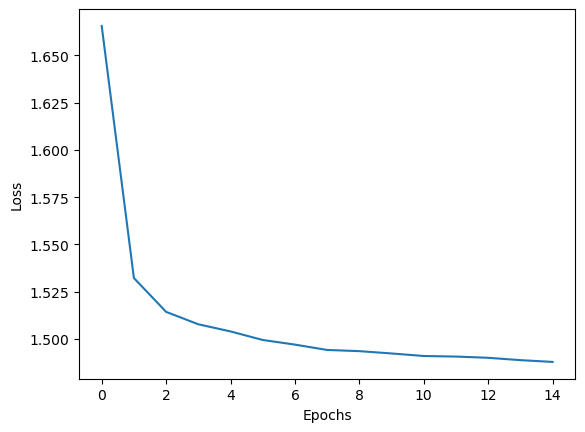

In [16]:
## Initialize the network parameters, loss function, optimizer, and device
mnist_dim = X.shape[1]
hidden_dim = int(mnist_dim/8)
output_dim = len(np.unique(mnist.target))

model = CNN(input_dim=mnist_dim, hidden_dim=hidden_dim, output_dim=output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Define the device to choose the fastest for training
## MPS for Apple Silicon, CUDA for NVidia GPUs, and CPU otherwise
device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'

## Define fit function
def fit(model, X_train, y_train, epochs=100):

    dataloader = DataLoader(dataset=TensorDataset(X_train, y_train), batch_size=128, shuffle=True, drop_last=True)
    model.to(device)
    model.train()

    losses = []
    for epoch in range(epochs):
        loss = 0
        for X_train, y_train in tqdm(dataloader, desc=f'Training Epoch {epoch+1}/{epochs}'):
            X_train = X_train.to(device)
            y_train = y_train.to(device)
            optimizer.zero_grad()
            outputs = model(X_train)
            batch_loss = criterion(outputs, y_train)
            batch_loss.backward()
            optimizer.step()
            loss += batch_loss.item()

        # average loss per batch
        loss = loss / len(dataloader)
        losses.append(loss)

        print(f'Epoch {epoch+1}/{epochs}: Loss: {loss:.4f}')

    return losses

## Define predict function
def predict(model, X):

    dataloader = DataLoader(dataset=TensorDataset(X), batch_size=128, drop_last=False)

    model.eval()
    device = next(model.parameters()).device
    with torch.no_grad():
        predicted = []
        for X, in tqdm(dataloader, desc='Predicting'):
            X = X.to(device)
            outputs = model(X)
            _, predicted_batch = torch.max(outputs, 1)
            predicted.append(predicted_batch.cpu())
    return torch.cat(predicted)

## Train the model
losses = fit(model, X_train_tensor, y_train_tensor, epochs=15)

## Plot the loss
plt.figure()
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Predicting: 100%|██████████| 165/165 [00:00<00:00, 199.63it/s]


Accuracy: 0.9845


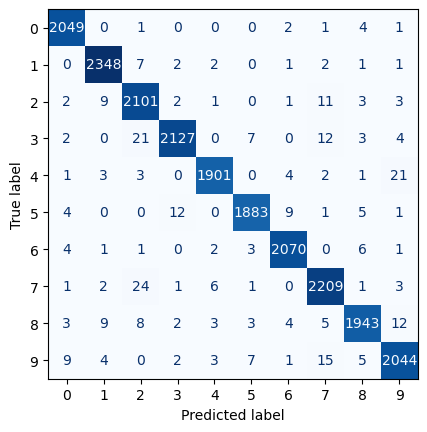

In [17]:
## Predict on the test set
y_pred_tensor = predict(model, X_test_tensor)
y_pred = y_pred_tensor.numpy()

## Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

## Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.arange(len(np.unique(y))))
disp.plot(cmap=plt.cm.Blues, values_format='d', colorbar=False);

- What accuracy did you get? Is it better than the fully connected network?

An accuracy of >98% should suffice for this example!

Let's take a look at some predictions that went wrong:

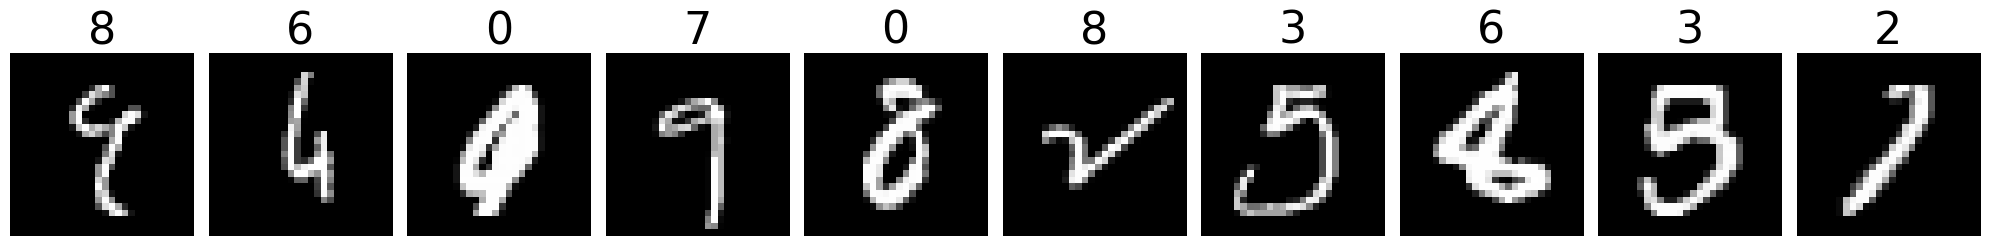

In [18]:
error_mask_cnn = y_pred != y_test
plot_example(X_test[error_mask_cnn], y_pred[error_mask_cnn])

- Let's further look at the accuracy of the convolutional network model (CNN) on the misclassified examples previously by the fully connected network (FCN).

In [21]:
accuracy = accuracy_score(y_test[error_mask_fcn], y_pred[error_mask_fcn])
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.6917


About 70% of the previously misclassified images are now correctly identified. 

Let's take a look at some of the misclassified examples before:

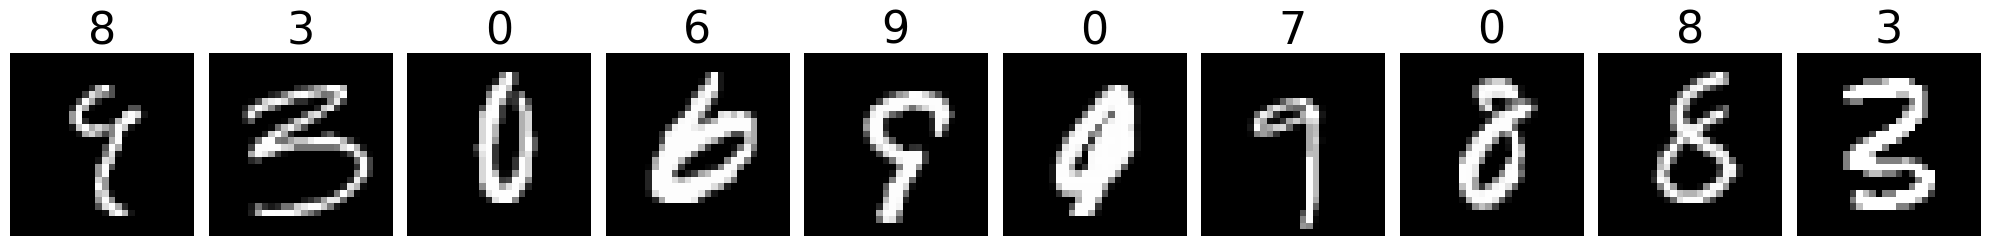

In [20]:
plot_example(X_test[error_mask_fcn], y_pred[error_mask_fcn])

- Last questions. Please take a look at the training loops of the fully connected network and the convolutional network. Comment on the similarities and differences.

You can see although the network architecture is different, the training loops are very similar. 

This is one feature of neural networks models. You can build significantly larger models and train them efficiently with a similar training loop, as long as you have enough computational power.   